In [120]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


import gc
import sys

import os
srcpath = os.path.realpath('../../SourceFiles')
sys.path.append(srcpath)

#from teproteus import TEProteusAdmin, TEProteusInst
#from tevisainst import TEVisaInst
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst

import mylib as ml

####
import time
import math
import ipywidgets as widgets
# from scipy import signal

In [121]:
SCLK = 2500e6  ### sampling clock
DUC_INTERP = 1  ### the DUC mode

In [122]:
# get the DAC mode, range, Serial port # and the data type of the system (8 or 16bit)
# Make sure the Model name is P9484M, that the name of our module
dac_mode, max_dac, sid, data_type = ml.connection_func() 


=========CONNECTING=========
process id 9412
Connected to: Tabor Electronics,P9484M,000000220642,1.118.0
Model: P9484M
===CONNECTION ESTABLISHED===

===SYSTEM'S INFORMATION===
DAC waveform format: 16 bits-per-point
Max DAC wave-point level: 65535
Half DAC wave-point level: 32767.0
Number of channels: 4
Max segment number: 65536
Available memory per DDR: 8,581,545,984 wave-bytes
==========READY============


In [123]:
admin = TepAdmin()  ### decalring a shortcut to send SCPY commands to the machine
inst = admin.open_instrument(slot_id=sid)  ### decalring a shortcut to send SCPY commands to the machine

In [124]:
channel_numb = 1
ml.initialization_func(channel_numb, inst, SCLK)  ### fix the inst


===INITIALIZATION OF CHANNEL 1===  -->  ===DONE===
ERRORS: 0, no error


In [125]:
sin_f, sin_f_seglen = ml.sin_func (100000, 0, SCLK, show_plot = False)  ### creating a sinus shape
blank, blank_seglen = ml.blank_func (SCLK)

sin_f = ml.digital_conv_func(sin_f, max_dac, data_type) ### converting the signal from float format array to a binary format array
blank = ml.digital_conv_func(blank, max_dac, data_type)

original seglen: 25000.0

!WARNING! The segment of the defined signal (25000.0 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

formated seglen: 24960
The blank singnal is with time width: 8.192e-07


In [126]:
def prepare_sin_pulse (width, frequency, SCLK, DUC_INTERP, max_dac, show_plot = True):
    """
    This funtion prepares a sin shaped pulse
    
    INPUTS:
        width - of the pulse [sec]
        frequency - of the signal
        
    OUTPUTS:
        I component of the signal
        Q component of the signal
        The length of the pulse in terms of number of data point (to be used when assigning to the AWG memory)
        """
    
    if DUC_INTERP != 1:
        print ('Attention the DUC Interpreter has a value different then 1.'.format(DUC_INTERP))
    
    frequency = frequency / DUC_INTERP
    # SCLK = SCLK/2.5
    
#     half_dac = max_dac // 2

    period = 1/frequency
    delta_t = 1/SCLK ### how much time between each two sequential signal points
#     sigma_numerical = sigma/delta_t  ### how many datapoints within a sigma

    print ("period = {0}[ns]".format(period*1e9))
#     print ("sigma = {0}[ns]".format(sigma*1e9))
#     print ("sigma_num = {0} datapoints ".format(sigma_numerical))

    width_seglen = width / delta_t # time width of the gaussian pulse, the width of the pulse terminates at 5*sigma, this is made by convention, it can be change to be (arbitrary number*sigma)
#     print (width_over_sigma, sigma_numerical, width)
    seglen_pulse = int(width_seglen)
    print("Sine segement length = {0} datapoints\n".format(seglen_pulse))
    print("Sine segement length (in time) = {0} [ns]]".format(width*1e9))

    
    seglen_pulse, normalization_factor = ml.formatter(seglen_pulse)


    t = np.linspace(start= 0, stop= 1, num= seglen_pulse, endpoint= False) 
    x = np.linspace(start= 0, stop= np.pi, num= seglen_pulse, endpoint= False) 
    
    FC = 5 * frequency * seglen_pulse * DUC_INTERP /2 / SCLK
    
#     print('Gaussian frequency = {0}[Mhz]'.format(SCLK * 2 * GAUS_FC / seglen_gauss / 1e6/ DUC_INTERP))  # the actual frequency of the sin wave in the gaussian
    print('Signal frequency = {0}[Mhz]'.format(FC / 1e6))  # the actual frequency of the sin wave in the gaussian

    
    ####################
    sin_envelope = np.sin(x)
    sin = np.sin(2*np.pi*t*FC)
    cos = np.cos(2*np.pi*t*FC)
#     gaussian = (1/ss/np.sqrt(2*np.pi)/2) * np.exp(-(t**2)/2/(ss**2)) / normalization_factor
    (i) = sin*sin_envelope
    (q) = cos*sin_envelope
    ####################
    
    if show_plot == True:
#         plt.plot(t, (i), '-')
        plt.plot(t, (i), '-',t, (q), '-')
        plt.legend(['I','Q'])



    
    return (i), (q), seglen_pulse


period = 250.0[ns]
Sine segement length = 32499 datapoints

Sine segement length (in time) = 13000.0 [ns]]

!WARNING! The segment of the defined signal (32499 points) does not comply with the format of the possible data chunk for a signal, which is ||| datalength = ( 64 * (32 + n)) |||, where         n is an integer.
-----------Will edit the signal automatically to suit the # of points-----------

Signal frequency = 0.000129792[Mhz]


<IPython.core.display.Javascript object>


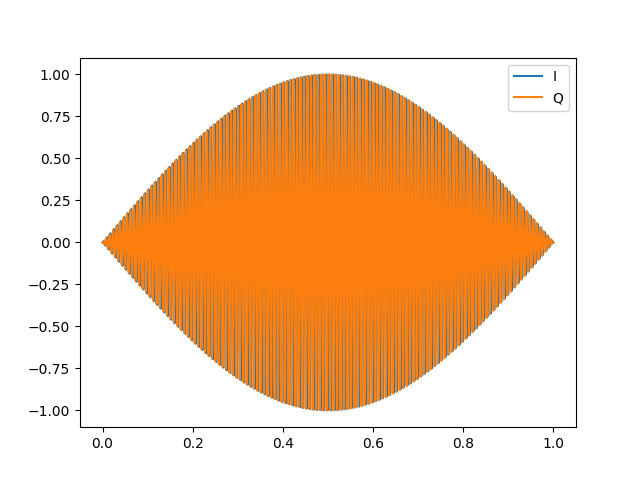

In [134]:
frequency = 4e6 ### frequency of the oscillation
width = 13e-6

sin_signal_i, sin_signal_q, seglen_sin = prepare_sin_pulse (width, frequency, SCLK, DUC_INTERP, max_dac, show_plot = True)

sin_signal_i = ml.digital_conv_func(sin_signal_i, max_dac, data_type)
sin_signal_q = ml.digital_conv_func(sin_signal_q, max_dac, data_type)

In [135]:
# frequency = 10e6 ### frequency of the oscillation
# sigma = 346e-08  ### make it bigger then the period of the oscillation 
# width_over_sigma = 5    # time width of the gaussian pulse, a.k.a. how many sigmas wide is the pulse, for example - width = [5*sigma], by 

# gauss_signal_i, gauss_signal_q, seglen_gauss = ml.prepare_gaussian_pulse (sigma, width_over_sigma, frequency, SCLK, DUC_INTERP, max_dac, show_plot = True)

# gauss_signal_i = ml.digital_conv_func(gauss_signal_i, max_dac, data_type)
# gauss_signal_q = ml.digital_conv_func(gauss_signal_q, max_dac, data_type)

In [137]:
channb = 1

# segnum = 1
# ml.download_signal(segnum, sin_f_seglen, channb, sin_f, sid) ### download signal to an approprate 'channel' and 'segment of the channel'

# segnum = 2
# ml.download_signal(segnum, sin_f_seglen, channb, sin_f, sid) #ml.download_signal(segnum,blank_seglen,channb,blank,sid) 

segnum = 3
ml.download_func(inst, sin_signal_i, channb, segnum) ### download signal to an approprate 'channel' and 'segment of the channel'

# segnum = 2
# ml.old_download_signal(segnum,seglen_gauss,channb,gauss_signal_i,sid)

wave size: 32448



In [130]:
# admin = TepAdmin()
# inst = admin.open_instrument(slot_id=sid)

In [131]:
print(inst)

In [132]:
wave = gauss_signal_i
wave2 = sin_f
wave3 = blank

In [29]:
# class signaler():
    
#     def __init__(self, sid):
#         admin = TepAdmin()
#         inst = admin.open_instrument(slot_id=sid)
#         self.inst = inst
#         pass
    
    
#     def new_download_func (wave, sid, channel, segment):

#         # download it to segment 1 of channel 1
#         self.inst.send_scpi_cmd(':INST:CHAN {0}'.format(channel))
#         self.inst.send_scpi_cmd(':TRAC:DEF {0},'.format(segment) + str(wave.size))
#         self.inst.send_scpi_cmd(':TRAC:SEL {0}'.format(segment))   # we are saying here basically "create for me a segment of memory with such and such length"

#         print('wave size: {0}'.format(wave.size))
#         # download the waveform to the selected segment
#         self.inst.write_binary_data(':TRAC:DATA', wave)  # put your wave there

#         self.inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM {0}'.format(segment))
#         # inst.send_scpi_cmd(':SOUR:VOLT 0.5')  ### set voltage 
#         self.inst.send_scpi_cmd(':OUTP ON')

#         resp = self.inst.send_scpi_query(':SYST:ERR?')
#         print(resp)

#         del wave

#         return None

#         #########################################
        
#     def simple_tasker (tasklen, channel):

#         cmd = ':INST:CHAN {0}'.format(channel)
#         self.inst.send_scpi_cmd(cmd )

#         cmd = ':TASK:COMP:LENG {0}'.format(tasklen)
#         self.inst.send_scpi_cmd(cmd )



#         for i in range(tasklen):
#             curr_task = i + 1
#             segnb = i + 1
#             cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
#             self.inst.send_scpi_cmd(cmd)
#             cmd = ':TASK:COMP:DTRigger ON'
#             self.inst.send_scpi_cmd(cmd)

#             if curr_task == 1: 
#                 cmd = ':TASK:COMP:ENAB CPU'

#             if curr_task==tasklen:
#                 cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
#                 self.inst.send_scpi_cmd(cmd)
#             else:
#                 cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
#                 self.inst.send_scpi_cmd(cmd)

#             cmd = ':TASK:COMP:TYPE SING'
#             self.inst.send_scpi_cmd(cmd)

#             cmd = ':TASK:COMP:LOOP {0}'.format(1)
#             self.inst.send_scpi_cmd(cmd)

#             cmd = ':TASK:COMP:SEGM {0}'.format(segnb)
#             self.inst.send_scpi_cmd(cmd)


#         cmd = ':TASK:COMP:WRIT'
#         self.inst.send_scpi_cmd(cmd)
#         print('Downloading Task table to channel {0}'.format(channel))

#         cmd = ':INST:CHAN {0}'.format(channel)
#         self.inst.send_scpi_cmd(cmd)

#         cmd = ':OUTP ON'
#         self.inst.send_scpi_cmd(cmd)

#         cmd = 'FUNC:MODE TASK'
#         self.inst.send_scpi_cmd(cmd)


#         resp = self.inst.send_scpi_query(':SYST:ERR?')
#         print(resp)




In [30]:
def new_download_func (inst, wave, sid, channel, segment):
    
    # download it to segment 1 of channel 1
    inst.send_scpi_cmd(':INST:CHAN {0}'.format(channel))
    inst.send_scpi_cmd(':TRAC:DEF {0},'.format(segment) + str(wave.size))
    inst.send_scpi_cmd(':TRAC:SEL {0}'.format(segment))   # we are saying here basically "create for me a segment of memory with such and such length"

    print('wave size: {0}'.format(wave.size))
    # download the waveform to the selected segment
    inst.write_binary_data(':TRAC:DATA', wave)  # put your wave there

    inst.send_scpi_cmd(':SOUR:FUNC:MODE:SEGM {0}'.format(segment))
    # inst.send_scpi_cmd(':SOUR:VOLT 0.5')  ### set voltage 
    inst.send_scpi_cmd(':OUTP ON')

    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)

    del wave
    
    return None

ml.download_func (inst, wave3, channel = 1, segment = 3)
ml.download_func (inst, wave2, channel = 1, segment = 2)
ml.download_func (inst, wave, channel = 1, segment = 1)

wave size: 2048
0, no error
wave size: 24960
0, no error
wave size: 43200
0, no error


In [46]:
def simple_tasker (inst, tasklen, channel):
    
    cmd = ':INST:CHAN {0}'.format(channel)
    inst.send_scpi_cmd(cmd )

    cmd = ':TASK:COMP:LENG {0}'.format(tasklen)
    inst.send_scpi_cmd(cmd )


    for i in range(tasklen):
        curr_task = i + 1
        segnb = i + 1
        print("Current task:",curr_task)
        
        cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
        inst.send_scpi_cmd(cmd)
        cmd = ':TASK:COMP:DTRigger ON'
        inst.send_scpi_cmd(cmd)

        # conditional statements to create closed loop task
        if curr_task == 1: 
            cmd = ':TASK:COMP:ENAB CPU'

        if curr_task==tasklen:
            cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
            inst.send_scpi_cmd(cmd)
            print("Next task will be task:",1)
        else:
            cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
            inst.send_scpi_cmd(cmd)
            print("Next task will be task:",curr_task+1)

        cmd = ':TASK:COMP:TYPE SING'
        inst.send_scpi_cmd(cmd)

        # define the number of loops for the specific task
        cmd = ':TASK:COMP:LOOP {0}'.format(curr_task)
        inst.send_scpi_cmd(cmd)

        # name the segment of memory to take the signal to be tasked with the aformentioned parameters from
        cmd = ':TASK:COMP:SEGM {0}'.format(segnb)
        inst.send_scpi_cmd(cmd)


    # write task to the machine
    cmd = ':TASK:COMP:WRIT'
    inst.send_scpi_cmd(cmd)
    print('Downloading Task table to channel {0}'.format(channel))

    # point to the channel
    cmd = ':INST:CHAN {0}'.format(channel)
    inst.send_scpi_cmd(cmd)

    # start the output
    cmd = ':OUTP ON'
    inst.send_scpi_cmd(cmd)

    # define the operation mode
    cmd = 'FUNC:MODE TASK'
    inst.send_scpi_cmd(cmd)


    # see if any errors came up
    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)
    
    return None
    
    
simple_tasker (inst, tasklen = 2, channel = 1)

Current task: 1
Next task will be task: 2
Current task: 2
Next task will be task: 1
0, no error


In [ ]:
##########################################

In [36]:
def simple_sequence_task (inst, channel, segment_pulse1 = int, segment_pulse2 = int, segment_time_delay = int):
    """This is simple quantum bit sequance pulser task. It sends one pulse, waits for some time and then sends some other pulse. 
    This is a TEMPLATE tasktable. To be used for more elaborate qubit manipulation sequences.
    
    INPUTS:
    inst - the instance of inst
    channel - channel number
    segment1
    segment2
    segment3
        
    OUTPUTS:
        None
    """
    
    cmd = ':INST:CHAN {0}'.format(channel)
    inst.send_scpi_cmd(cmd )

    # what is the length of this task sequence
    cmd = ':TASK:COMP:LENG {0}'.format(3) ### SET TO 3, because of the 3 segments !!! INCREASE IF NEEDED !!!
    inst.send_scpi_cmd(cmd )
    
    def subroutine (curr_task, segnb, tasklen, loops):

            cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
            inst.send_scpi_cmd(cmd)
            cmd = ':TASK:COMP:DTRigger ON'
            inst.send_scpi_cmd(cmd)

            # conditional statements to create closed loop task
            if curr_task == 1: 
                cmd = ':TASK:COMP:ENAB CPU'

            if curr_task==tasklen:
                cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
                inst.send_scpi_cmd(cmd)
            else:
                cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
                print("Next task:",curr_task)
                inst.send_scpi_cmd(cmd)

            cmd = ':TASK:COMP:TYPE SING'
            inst.send_scpi_cmd(cmd)

            # define the number of loops for the specific task
            cmd = ':TASK:COMP:LOOP {0}'.format(loops)
            inst.send_scpi_cmd(cmd)

            # name the segment of memory to take the signal to be tasked with the aformentioned parameters from
            cmd = ':TASK:COMP:SEGM {0}'.format(segnb)
            inst.send_scpi_cmd(cmd)
        
    ###############################################
    
    subroutine (curr_task = 1, segnb = segment_pulse2, tasklen = 3, loops = 1)
    subroutine (curr_task = 2, segnb = segment_time_delay, tasklen = 3, loops = 10)
    subroutine (curr_task = 3, segnb = segment_pulse2, tasklen = 3, loops = 1)
    

    # write task to the machine
    cmd = ':TASK:COMP:WRIT'
    inst.send_scpi_cmd(cmd)
    print('Downloading Task table to channel {0}'.format(channel))

    # point to the channel
    cmd = ':INST:CHAN {0}'.format(channel)
    inst.send_scpi_cmd(cmd)

    # start the output
    cmd = ':OUTP ON'
    inst.send_scpi_cmd(cmd)

    # define the operation mode
    cmd = 'FUNC:MODE TASK'
    inst.send_scpi_cmd(cmd)


    # see if any errors came up
    resp = inst.send_scpi_query(':SYST:ERR?')
    print(resp)
    
    return None

simple_sequence_task (inst, channel = 1, segment_pulse1 = 1, segment_pulse2 = 2, segment_time_delay = 3)

Next task: 1
Next task: 2
0, no error


In [ ]:
#########################################

In [138]:
inst.close_instrument()
admin.close_inst_admin()

# ml.quitter(sid)

0